In [19]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas

In [70]:
# three11_data = pd.read_csv("https://data.wprdc.org/datastore/dump/76fda9d0-69be-4dd5-8108-0de7907fc5a4")
#Alternate command
three11_data = pd.read_csv('76fda9d0-69be-4dd5-8108-0de7907fc5a4.csv')
hood_csv = pd.read_csv('https://data.wprdc.org/datastore/dump/668d7238-cfd2-492e-b397-51a6e74182ff')

In [3]:
road_obstructions = three11_data[(three11_data.REQUEST_TYPE == "Street Obstruction/Closure")|(three11_data.REQUEST_TYPE == "Potholes")|(three11_data.REQUEST_TYPE == "Road")]

road_obstructions.head()

,REQUEST_ID,CREATED_ON,REQUEST_TYPE,REQUEST_ORIGIN,STATUS,DEPARTMENT,NEIGHBORHOOD,COUNCIL_DISTRICT,WARD,TRACT,PUBLIC_WORKS_DIVISION,PLI_DIVISION,POLICE_ZONE,FIRE_ZONE,X,Y,GEO_ACCURACY
0,203364.0,2017-12-15T14:53:00,Street Obstruction/Closure,Call Center,1,DOMI - Permits,Central Northside,1.0,22.0,4.200322e+10,1.0,22.0,1.0,1-7,-80.016716,40.454144,EXACT
16,184586.0,2017-09-05T11:50:00,Street Obstruction/Closure,Call Center,1,DOMI - Permits,Lower Lawrenceville,7.0,6.0,4.200309e+10,2.0,6.0,2.0,3-3,-79.966906,40.471717,EXACT
17,183065.0,2017-08-29T10:53:00,Street Obstruction/Closure,Call Center,1,DOMI - Permits,Windgap,2.0,20.0,4.200356e+10,5.0,20.0,6.0,1-16,-80.073213,40.457633,EXACT
21,181351.0,2017-08-22T15:31:00,Street Obstruction/Closure,Call Center,1,DOMI - Permits,Carrick,4.0,29.0,4.200329e+10,3.0,29.0,3.0,4-23,-79.981714,40.381741,EXACT
25,177411.0,2017-08-08T08:18:00,Street Obstruction/Closure,Call Center,1,DOMI - Permits,North Oakland,8.0,5.0,4.200356e+10,3.0,5.0,4.0,2-23,-79.952022,40.451890,EXACT


In [63]:
num_ro = road_obstructions['NEIGHBORHOOD'].value_counts()
num_ro

Brookline                3782
Squirrel Hill South      2762
Bloomfield               2667
Carrick                  2593
Central Lawrenceville    1802
                         ... 
St. Clair                  76
Chartiers City             57
Glen Hazel                 40
Arlington Heights          29
Mount Oliver Borough       16
Name: NEIGHBORHOOD, Length: 91, dtype: int64

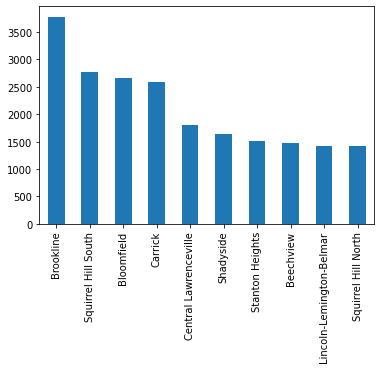

In [64]:
num_ro.head(10).plot.bar()

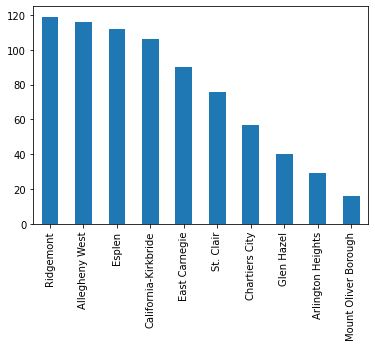

In [25]:
num_ro.tail(10).plot.bar()

In [69]:
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
neighborhoods

,objectid,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,...,shape_ar_1,page_numbe,plannerass,created_us,created_da,last_edite,last_edi_1,Shape__Are,Shape__Len,geometry
0,1,0.0,42,003,040500,1,420030405001,Block Group 1,G5030,S,...,7.843108e+06,15,Derek Dauphin,pgh.admin,2019-10-23T14:17:16.403Z,pgh.admin,2019-10-23T14:17:16.403Z,7.842997e+06,11525.904546,"POLYGON ((-79.95304 40.44203, -79.95302 40.442..."
1,2,1.0,42,003,040400,1,420030404001,Block Group 1,G5030,S,...,1.390463e+07,15,Derek Dauphin,pgh.admin,2019-10-23T14:17:16.403Z,pgh.admin,2019-10-23T14:17:16.403Z,1.390469e+07,20945.562570,"POLYGON ((-79.95455 40.45882, -79.95427 40.458..."
2,3,2.0,42,003,040200,2,420030402002,Block Group 2,G5030,S,...,5.999801e+06,15,Derek Dauphin,pgh.admin,2019-10-23T14:17:16.403Z,pgh.admin,2019-10-23T14:17:16.403Z,5.998649e+06,18280.484515,"POLYGON ((-79.96230 40.44294, -79.96220 40.442..."
3,4,3.0,42,003,030500,2,420030305002,Block Group 2,G5030,S,...,7.202139e+06,15,Derek Dauphin,pgh.admin,2019-10-23T14:17:16.403Z,pgh.admin,2019-10-23T14:17:16.403Z,7.203337e+06,15697.914337,"POLYGON ((-79.98275 40.44641, -79.98273 40.446..."
4,5,5.0,42,003,020300,1,420030203001,Block Group 1,G5030,S,...,1.694785e+07,15,Andrea Lavin Kossis,pgh.admin,2019-10-23T14:17:16.403Z,pgh.admin,2019-10-23T14:17:16.403Z,1.694875e+07,24019.532672,"POLYGON ((-79.97494 40.45629, -79.97484 40.456..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,88,298.0,42,003,563100,3,420035631003,Block Group 3,G5030,S,...,1.027890e+07,15,Sophia Robison,pgh.admin,2019-10-23T14:17:16.403Z,pgh.admin,2019-10-23T14:17:16.403Z,1.024662e+07,16308.779881,"POLYGON ((-80.03431 40.43366, -80.03424 40.433..."
86,89,32.0,42,003,562600,1,420035626001,Block Group 1,G5030,S,...,5.579501e+06,15,Sophia Robison,pgh.admin,2019-10-23T14:17:16.403Z,pgh.admin,2019-10-23T14:17:16.403Z,5.579476e+06,18778.991513,"POLYGON ((-80.02869 40.44454, -80.02845 40.444..."
87,90,57.0,42,003,250700,1,420032507001,Block Group 1,G5030,S,...,6.050988e+06,15,Stephanie Joy Everett,pgh.admin,2019-10-23T14:17:16.403Z,pgh.admin,2019-10-23T14:17:16.403Z,6.050817e+06,11709.518764,"POLYGON ((-80.02039 40.46285, -80.02022 40.462..."
88,91,96.0,42,003,562300,2,420035623002,Block Group 2,G5030,S,...,1.271304e+07,15,Ose Akinlotan,pgh.admin,2019-10-23T14:17:16.403Z,pgh.admin,2019-10-23T14:17:16.403Z,1.271295e+07,18931.494331,"POLYGON ((-79.92030 40.41205, -79.92027 40.412..."


In [82]:
ro_map = neighborhoods.merge(num_ro, left_on="hood", right_on="NEIGHBORHOOD")

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

Incidents per Square Mile

In [81]:
hood_csv.filter(["hood", "sqmiles"])

,hood,sqmiles
0,Chateau,0.383
1,Summer Hill,0.439
2,Northview Heights,0.313
3,Spring Hill-City View,0.630
4,Perry South,0.905
...,...,...
85,Overbrook,0.839
86,Chartiers City,0.132
87,Esplen,0.230
88,Ridgemont,0.369
